# GStar and interference contributions

## Generate histograms

In [1]:
import zdb
import glob
import os
import oyaml as yaml
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dftools
import scipy
import pysge
from tqdm.auto import tqdm

plt.style.use('cms')
plt.rcParams.update({
    "figure.dpi": 150,
    "figure.figsize": (4, 3),
    "lines.markersize": 3,
    "errorbar.capsize": 2,
    "font.size": 10.,
})

Welcome to JupyROOT 6.18/00


In [2]:
def generate_yaml(hists, selection, filepath, tables={"central": "Events"}, systs=[], mc=False):
    hists_def = {
        "_".join(k): [
            {"table": "df: '{table_name}'"},
            {"varname0": "df: '{}'".format(k[0])},
            {"varname1": "df: '{}'".format(k[1])},
            {"selection": "df: '{selection_name}'"},
            {"parent": "df: df.parent"},
            {"binvar0": "df: df.{}_bin".format(k[0])},
            {"binvar1": "df: df.{}_bin".format(k[1])},
            {"count": "df: 1."},
            {"sum_w": "df: {weight}"},
            {"sum_ww": "df: df.sum_w**2"},
        ] for k in hists
    }
    
    if mc:
        for key, hdef in hists_def.items():
            for label, vari in systs:
                hdef.extend([
                    {"sum_w_{}".format(label): "df: df.sum_w*({})".format(vari)},
                    {"sum_ww_{}".format(label): "df: (df.sum_w*({}))**2".format(vari)},
                ])
    
    monojet_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5"]
    monojetqcd_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX<=0.5"]
    singlemuon_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    singlemuonplus_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125.", "LeptonCharge==1."]
    singlemuonminus_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125.", "LeptonCharge==-1."]
    singlemuonqcd_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX<=0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    doublemuon_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doublemuonqcd_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX<=0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    singleelectron_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX>0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100."]
    singleelectronplus_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX>0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100.", "LeptonCharge==1."]
    singleelectronminus_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX>0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100.", "LeptonCharge==-1."]
    singleelectronqcd_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX<=0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100."]
    doubleelectron_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX>0.5", "nElectronSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doubleelectronqcd_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX<=0.5", "nElectronSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    singletau_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nTauSelection==1"]
    singlemuonmu_selection = selection + ["SingleMuonTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    singlemuonmuqcd_selection = selection + ["SingleMuonTriggered", "MinDPhiJ1234METnoX<=0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    doublemuonmu_selection = selection + ["SingleMuonTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doublemuonmuqcd_selection = selection + ["SingleMuonTriggered", "MinDPhiJ1234METnoX<=0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    if not mc:
        monojet_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==0"])
        monojetqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==0"])
        singlemuon_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonplus_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonminus_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonqcd_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        doublemuon_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonqcd_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        singleelectron_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        singleelectronplus_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        singleelectronminus_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        singleelectronqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        doubleelectron_selection.extend(["nMuonVeto==0", "nElectronVeto==2", "nTauVeto==0"])
        doubleelectronqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==2", "nTauVeto==0"])
        singletau_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==1"])
        singlemuonmu_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonmuqcd_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonmu_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonmuqcd_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
    else:
        monojet_selection.extend(["nTauSelection==0"])
        monojetqcd_selection.extend(["nTauSelection==0"])
        singlemuon_selection.extend(["nTauSelection==0"])
        singlemuonplus_selection.extend(["nTauSelection==0"])
        singlemuonminus_selection.extend(["nTauSelection==0"])
        singlemuonqcd_selection.extend(["nTauSelection==0"])
        doublemuon_selection.extend(["nTauSelection==0"])
        doublemuonqcd_selection.extend(["nTauSelection==0"])
        singleelectron_selection.extend(["nTauSelection==0"])
        singleelectronplus_selection.extend(["nTauSelection==0"])
        singleelectronminus_selection.extend(["nTauSelection==0"])
        singleelectronqcd_selection.extend(["nTauSelection==0"])
        doubleelectron_selection.extend(["nTauSelection==0"])
        doubleelectronqcd_selection.extend(["nTauSelection==0"])
        singlemuonmu_selection.extend(["nTauSelection==0"])
        singlemuonmuqcd_selection.extend(["nTauSelection==0"])
        doublemuonmu_selection.extend(["nTauSelection==0"])
        doublemuonmuqcd_selection.extend(["nTauSelection==0"])
        

    cutflows = {
        "DoubleMuon": {
            "selection_name": "DoubleMuon",
            "selection": "(" + ") & (".join(doublemuon_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleMuon",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "Electron", "Tau",
            ])],
        },
        "DoubleElectron": {
            "selection_name": "DoubleElectron",
            "selection": "(" + ") & (".join(doubleelectron_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleElectron",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "Muon", "Tau",
            ])],
        },
    }

    met_triggers = [
        "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
        "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
        "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
        "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
        "(df.HLT_PFMET170_NotCleaned & (df.run<276282))",
        "(df.HLT_PFMET170_BeamHaloCleaned & (df.run<276282))",
        "df.HLT_PFMET170_HBHECleaned",
        "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
        "df.HLT_MET75_IsoTrk50",
    ]
    if mc:
        met_triggers = [
            "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
            "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
            "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
            "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
            "df.HLT_PFMET170_NotCleaned",
            "df.HLT_PFMET170_BeamHaloCleaned",
            "df.HLT_PFMET170_HBHECleaned",
            "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
            "df.HLT_MET75_IsoTrk50",
        ]
        
    singlemuon_triggers = ["df.HLT_IsoMu24", "df.HLT_IsoTkMu24"]
    singleelectron_triggers = [
        "df.HLT_Ele27_WPTight_Gsf",
        "df.HLT_Ele115_CaloIdVT_GsfTrkIdT",
    ]

    cfg_eval_bins = [
        {"Generator_id1_bin": "df: np.floor(np.maximum(df.Generator_id1, df.Generator_id2)/1.)*1."},
        {"Generator_id2_bin": "df: np.floor(np.minimum(df.Generator_id1, df.Generator_id2)/1.)*1."},
    ]
    
    if mc:
        weight = [
            "df.WeightXsLumi",
            "df.WeightQcdEwk",
            "df.WeightPU",
            "df.WeightPreFiring",
            "df.WeightOneMinusPhotonVetoIdLoose",
            "df.WeightOneMinusPhotonVetoPixelSeedVeto",
            "df.WeightOneMinusJetBVetoIdMedium",
        ]
        weight_ele_veto = [
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronSelectionIdIsoTight",
            "df.WeightOneMinusElectronVetoReco",
        ]
        weight_ele_sele = [
            "df.WeightElectronSelectionIdIsoTight",
            "df.WeightElectronSelectionReco",
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronVetoNoSelectionReco",
        ]
        weight_mu_veto = [
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
            "df.WeightOneMinusMuonSelectionIdTight",
            "df.WeightOneMinusMuonSelectionIsoTight",
        ]
        weight_mu_sele = [
            "df.WeightMuonSelectionIdTight",
            "df.WeightMuonSelectionIsoTight",
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
        ]
        weight_tau_veto = [
            #"df.WeightOneMinusTauSelectionIdTight",
            "df.WeightOneMinusTauVetoNoSelectionIdVLoose",
        ]
        weight_tau_sele = [
            #"df.WeightTauSelectionIdTight",
            "df.WeightOneMinusTauVetoNoSelectionIdVLoose",
        ]
        weight_met_trig = ["df.WeightMETTrig",]
        weight_singleele_trig = ["df.WeightSingleElectronTrig"]
        weight_singlemu_trig = ["df.WeightSingleMuonTrig"]
        
        cfg_eval_bins.extend([
            {"parent": "df: np.where( df.parent.isin(['WJetsToLNu', 'DYJetsToLL']), np.where( df.parent=='WJetsToLNu', np.where( df.LeptonCharge>0, np.where( df.LeptonIsElectron, np.full_like(df.parent, 'WJetsToEPlusNu'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'WJetsToMuPlusNu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'WJetsToTauHPlusNu'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'WJetsToTauLPlusNu'), np.full_like(df.parent, 'WJetsToTauPlusNu'), ), ), np.full_like(df.parent, 'WJetsToLPlusNu'), ), ), ), np.where( df.LeptonIsElectron, np.full_like(df.parent, 'WJetsToEMinusNu'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'WJetsToMuMinusNu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'WJetsToTauHMinusNu'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'WJetsToTauLMinusNu'), np.full_like(df.parent, 'WJetsToTauMinusNu'), ), ), np.full_like(df.parent, 'WJetsToLMinusNu'), ), ), ), ), np.where( df.parent=='DYJetsToLL', np.where(  df.LeptonIsElectron, np.full_like(df.parent, 'DYJetsToEE'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'DYJetsToMuMu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'DYJetsToTauHTauH'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'DYJetsToTauHTauL'), np.where( df.nGenTauL==2, np.full_like(df.parent, 'DYJetsToTauLTauL'), np.full_like(df.parent, 'DYJetsToTauTau'), ), ), ), np.full_like(df.parent, 'DYJetsToLL'), ), ), ), df.parent, ), ), df.parent, )"},
            {"Weight_Monojet": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_veto+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_MonojetQCD": "df: df.Weight_Monojet"},
            {"Weight_SingleMuon": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_SingleMuonPlus": "df: df.Weight_SingleMuon"},
            {"Weight_SingleMuonMinus": "df: df.Weight_SingleMuon"},
            {"Weight_SingleMuonQCD": "df: df.Weight_SingleMuon"},
            {"Weight_DoubleMuon": "df: df.Weight_SingleMuon"},
            {"Weight_SingleElectron": "df: (" + ")*(".join(weight+weight_ele_sele+weight_mu_veto+weight_tau_veto+weight_singleele_trig)+")"},
            {"Weight_SingleElectronPlus": "df: df.Weight_SingleElectron"},
            {"Weight_SingleElectronMinus": "df: df.Weight_SingleElectron"},
            {"Weight_SingleElectronQCD": "df: df.Weight_SingleElectron"},
            {"Weight_DoubleElectron": "df: df.Weight_SingleElectron"},
            {"Weight_SingleTau": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_veto+weight_tau_sele+weight_met_trig)+")"},
            {"Weight_SingleMuonMu": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_singlemu_trig)+")"},
            {"Weight_SingleMuonMuQCD": "df: df.Weight_SingleMuonMu"},
            {"Weight_DoubleMuonMu": "df: df.Weight_SingleMuonMu"},
        ])
        
    cfg_eval_bins.extend([
        {"METTriggered": "df: (" + ") | (".join(met_triggers) + ")"},
        {"SingleMuonTriggered": "df: (" + ") | (".join(singlemuon_triggers) + ")"},
        {"SingleElectronTriggered": "df: (" + ") | (".join(singleelectron_triggers) + ")"},
    ])

    cfg = {
        "query": {
            "groupby": ["table", "varname0", "varname1", "selection", "parent", "binvar0", "binvar1"],
            "tables": tables,
            "aliases": {},
            "eval": cfg_eval_bins,
            "cutflows": cutflows,
            "hists": hists_def,
        },
        "files": sorted(p for p in glob.glob(filepath)),
    }
    
    return cfg

In [3]:
hists = [("Generator_id1", "Generator_id2")]
systs = []

mc_selection = [
    "(parent!='EWKV2Jets' | nGenBosonSelection==1)", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter",
    "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter",
    "Flag_BadPFMuonFilter", "MET_dCaloMET<0.5", "nJetSelection>0",
    "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8",
    "LeadJetSelection_pt>200.", "METnoX_pt>200.",
]

cfg_mc = generate_yaml(
    hists, mc_selection,
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/14_skims/mc/*.h5",
    systs=systs,
    mc=True,
)
with open("configs/mc_id1_id2.yaml", "w") as f:
    yaml.dump(cfg_mc, f, indent=4)

In [4]:
!~/Scripts/batch/QSTAT.py


 queue   |   free |   used |   total
---------+--------+--------+---------
 hep.q   |    272 |    168 |     440
 gpu.q   |      7 |      0 |       7
 fw.q    |      4 |      0 |       4

 user   |     hep.q |           |
        |   running |   pending | duration
--------+-----------+-----------+-----------------
 Brais  |       152 |        84 | 0 days 02:45:01
 Edward |        16 |         0 | 0 days 01:10:01



In [5]:
#zdb.modules.analyse(
#    "configs/mc_id1_id2.yaml",
#    output="hists_1d_gstar.h5:MCAggEvents",
#    mode='sge',
#    ncores=-1,
#    batch_opts="-q hep.q -l h_rt=3:0:0 -l h_vmem=12G",
#    chunksize=500_000,
#    merge_opts={"mode": "sge", "ncores": 10, "batch_opts": "-q hep.q"},
#)

## Draw

In [6]:
df = pd.read_hdf("hists_id1_id2.h5", "MCAggEvents")
df.head(5)

count  \
table   varname0      varname1      selection      parent     binvar0 binvar1          
central Generator_id1 Generator_id2 DoubleElectron DYJetsToEE -5.0    -5.0      57.0   
                                                              -4.0    -5.0     214.0   
                                                                      -4.0     109.0   
                                                              -3.0    -5.0     248.0   
                                                                      -4.0     539.0   

                                                                                  sum_w  \
table   varname0      varname1      selection      parent     binvar0 binvar1             
central Generator_id1 Generator_id2 DoubleElectron DYJetsToEE -5.0    -5.0     0.088622   
                                                              -4.0    -5.0     0.576054   
                                                                      -4.0     0.565146   
                                                              -3.0    -5.0     1.128446   
                                                                      -4.0     4.403699   

                                                                                 sum_ww  
table   varname0      varname1      selection      parent     binvar0 binvar1            
central Generator_id1 Generator_id2 DoubleElectron DYJetsToEE -5.0    -5.0     0.002458  
                                                              -4.0    -5.0     0.079145  
                                                                      -4.0     0.160089  
                                                              -3.0    -5.0     0.149478  
                                                                      -4.0     0.718964

In [55]:
bins = np.array([-5, -4 ,-3, -2, -1, 1, 2, 3, 4, 5, 21])
df = dftools.transform.rebin(df, bins, label="binvar0")
df = dftools.transform.rebin(df, bins, label="binvar1")

dfmm = df.loc[("central", "Generator_id1", "Generator_id2", "DoubleMuon", "DYJetsToMuMu"),("sum_w",)]
dfmm = dfmm/dfmm.sum()

dfee = df.loc[("central", "Generator_id1", "Generator_id2", "DoubleElectron", "DYJetsToEE"),("sum_w",)]
dfee = dfee/dfee.sum()

dfll = df.loc[("central", "Generator_id1", "Generator_id2")]
dfll = dfll.unstack().unstack().loc[[
    ("DoubleMuon", "DYJetsToMuMu"),
    ("DoubleElectron", "DYJetsToEE"),
],:].stack().stack().groupby(["binvar0", "binvar1"]).sum().loc[:,("sum_w",)]
dfll = dfll/dfll.sum()
dfll.head(5)

sum_w
binvar0 binvar1          
-5      -5       0.000005
        -4       0.000000
        -3       0.000000
        -2       0.000000
        -1       0.000000

In [56]:
conv = {
    -5: r'$\bar{b}$', -4: r'$\bar{c}$', -3: r'$\bar{s}$', -2: r'$\bar{u}$', -1: r'$\bar{d}$',
    1: r'$d$', 2: r'$u$', 3: r'$s$', 4: r'$c$', 5: r'$b$', 21: r'$g$',
}

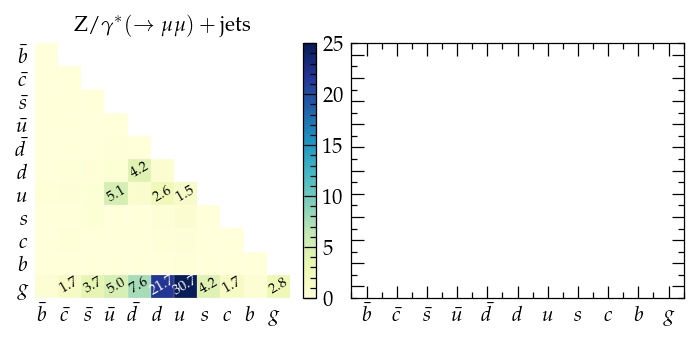

In [57]:
df_draw = dfmm.unstack().fillna(0.)
x = [conv[v] for v in df_draw.index.get_level_values("binvar0").values]
y = [conv[v[1]] for v in df_draw.columns.values]
z = df_draw.values*100

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        if i < j:
            z[i,j] = np.nan

fig, ax = plt.subplots(
    figsize=(6, 2.25), dpi=150,
    nrows=1, ncols=2,
    sharex=True, sharey=True,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

im, bar = dftools.draw.heatmap(
    z, y, x, ax[0], cmap="YlGnBu",
    cbarlabel=r'',
    grid_kw={"linewidth": 0.1},
)
dftools.draw.annotate_heatmap(
    im, data=z, valfmt='{x:.1f}',
    textcolors=['black', 'white'],
    cthreshold=lambda z: z>10.,
    vthreshold=lambda z: z>1.,
    fontsize=7, rotation=30,
)
bar.mappable.set_clim(0., 25.)
ax[0].set_title(r'$\mathrm{Z}/\gamma^*(\rightarrow\mu\mu)+\mathrm{jets}$', fontsize=10)
pass

In [58]:
df_draw = dfee.unstack().fillna(0.)
x = [conv[v] for v in df_draw.index.get_level_values("binvar0").values]
y = [conv[v[1]] for v in df_draw.columns.values]
z = df_draw.values*100

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        if i < j:
            z[i,j] = np.nan

im, bar = dftools.draw.heatmap(
    z, y, x, ax[1], cmap="YlGnBu",
    cbarlabel=r'',
    grid_kw={"linewidth": 0.1},
)
dftools.draw.annotate_heatmap(
    im, data=z, valfmt='{x:.1f}',
    textcolors=['black', 'white'],
    cthreshold=lambda z: z>10.,
    vthreshold=lambda z: z>1.,
    fontsize=7, rotation=30,
)
bar.mappable.set_clim(0., 25.)
ax[1].set_title(r'$\mathrm{Z}/\gamma^*(\rightarrow ee)+\mathrm{jets}$', fontsize=10)
pass

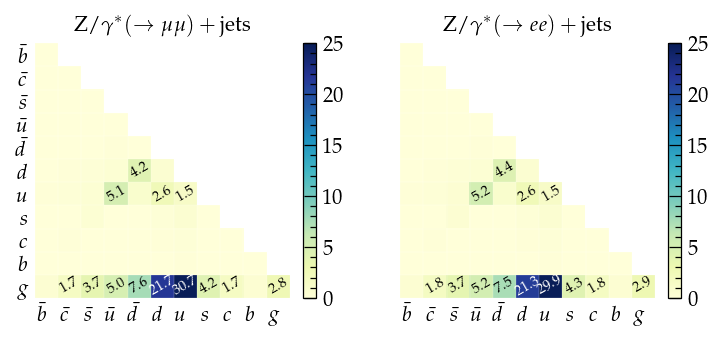

In [59]:
fig

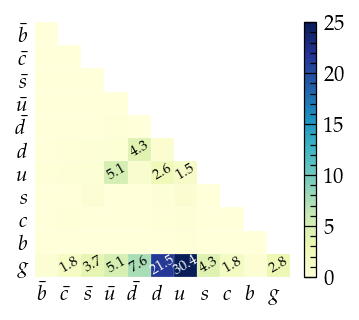

In [60]:
df_draw = dfll.unstack().fillna(0.)
x = [conv[v] for v in df_draw.index.get_level_values("binvar0").values]
y = [conv[v[1]] for v in df_draw.columns.values]
z = df_draw.values*100

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        if i < j:
            z[i,j] = np.nan

fig, ax = plt.subplots(
    figsize=(3, 2.25), dpi=150,
)

im, bar = dftools.draw.heatmap(
    z, y, x, ax, cmap="YlGnBu",
    cbarlabel=r'',
    grid_kw={"linewidth": 0.1},
)
dftools.draw.annotate_heatmap(
    im, data=z, valfmt='{x:.1f}',
    textcolors=['black', 'white'],
    cthreshold=lambda z: z>10.,
    vthreshold=lambda z: z>1.,
    fontsize=7, rotation=30,
)
bar.mappable.set_clim(0., 25.)
pass

In [64]:
dfll.columns = ["weight"]
dfll.index.names = ["Generator_id1", "Generator_id2"]
dfll.to_hdf(
    "reweight_id1_id2", "MCWeight",
    format='table', append=False,
    complevel=9, complib='zlib',
)